We're going to investigate the RHL's reinterpretation of the ZOGY (2016) algorithm which is described in RHL's slides as a post-convolution (in Fourier space) of the diffim:

$$
D(k) = [I_1(k) - \kappa(k) I_2(k)] \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}},
$$

where $I_1$ and $I_2$ are the two images, $\sigma_1$ and $\sigma_2$ are their respective variances, and $\kappa$ is the PSF-matching kernel. Note that this is for the case of "preconvolution" of $I_1$ with its own PSF, so that if $I_1$ and $I_2$ have the same seeing, then $\kappa$ = $\phi_1$ (where $\phi_1$ is the PSF of $I_1$). The resulting PSF of the diffim $D$ is:

$$
\phi_D(k) = \phi_1(k) \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

Thus, we may interpret the image difference as being **post-convolved** with a kernel of the form

$$
\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

If we wish to incorporate this post-convolution into our current framework which works in real-space, it is "simply" a matter of inverse Fourier-transforming the kernel into real-space, and then convolving it with the diffim.

But what does this post-convolution kernel (and the PSF of the image difference) actually look like?

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

## Let's do the calculations (FFTs and iFFTs) numerically instead...

In [3]:
from scipy.fftpack import fft, ifft, fftfreq

(-3, 3)

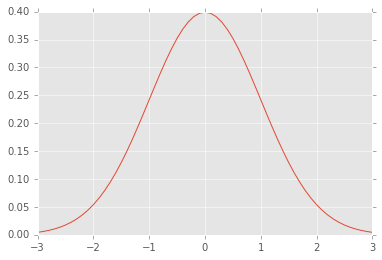

In [4]:
def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

x = np.arange(-5,5,0.1)
plt.plot(x, gaussian(x))
plt.xlim(-3, 3)

(-3, 3)

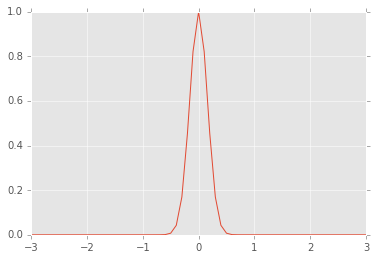

In [5]:
def gaussian_ft(x, m=0., s=1.0):
    kp = gaussian(x, m, s)
    npts = len(x)
    FFT = fft(kp)
    FFT *= (x[1]-x[0])
    freqs = fftfreq(npts, x[1]-x[0])  # assumes uniformly sampled x!
    return FFT, freqs

FFT, freqs = gaussian_ft(x, s=1.)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(abs(FFT)))
plt.xlim(-3, 3)

(-3, 3)

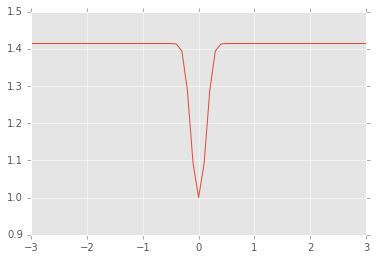

In [6]:
# post_conv_kernel = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
def post_conv_kernel_ft(x, sig1=1., sig2=1., m=0., sigk=1.):
    kft, freqs = gaussian_ft(x, m, sigk)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2)), freqs

kft, freqs = post_conv_kernel_ft(x, sigk=1.)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(kft.real))
plt.xlim(-3, 3)

-0.0135174826775
-0.0134769965608
1.0


(-0.02, 0.01)

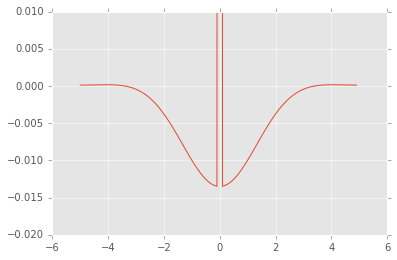

In [7]:
def post_conv_kernel(x, sig1=1., sig2=1., m=0., sigk=1.):
    kft, freqs = post_conv_kernel_ft(x, sig1, sig2, m, sigk)
    out = ifft(kft)
    return out

pck = post_conv_kernel(x, sigk=1.)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.02, 0.01)

Let's look at the PSF of the diffim: $\phi_D$ in $k$ space and real space.

(-3, 3)

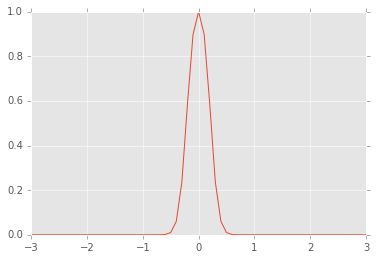

In [8]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".
def post_conv_psf_ft(x, sig1=1., sig2=1., m=0., sigk=1., psfsig1=1.):
    kft, freqs = gaussian_ft(x, m, sigk)
    sig1ft, freqs = gaussian_ft(x, m, psfsig1)
    return sig1ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2)), freqs

pft, freqs = post_conv_psf_ft(x, sigk=1., psfsig1=1.)
plt.plot(np.fft.fftshift(freqs), np.fft.fftshift(abs(pft)))
plt.xlim(-3, 3)

0.0457879443376
-0.00102900824982
1.0
1.0


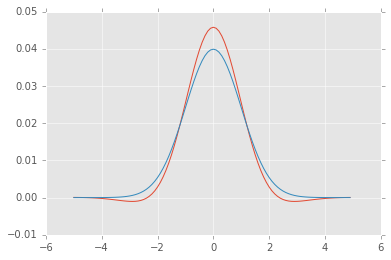

In [9]:
def post_conv_psf(x, sig1=1., sig2=1., m=0., sigk=1., psfsig=1.):
    kft, freqs = post_conv_psf_ft(x, sig1, sig2, m, sigk, psfsig)
    #kft *= (freqs[1] - freqs[0])
    out = ifft(kft)
    return out

pcf = post_conv_psf(x, sigk=1., psfsig=1.)
print pcf.real.max()
print pcf.real.min()
print pcf.real.sum()
plt.plot(x, pcf.real)
phi1 = gaussian(x, m=0., s=1.) * (x[1]-x[0]) ## compare to phi_1(x)
print phi1.sum()
plt.plot(x, phi1)
#plt.ylim(-0.0015, 0.0001)

This is close to the figure in RHL's slides but I need to understand why the amplitude is ~10x off and why the "pcf" goes negative.

## Make some fake data and test this all out...

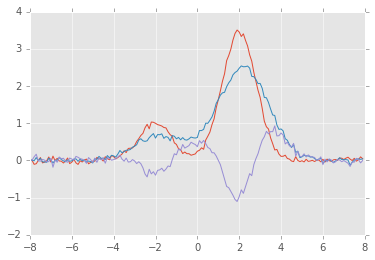

In [76]:
xim = np.arange(-8, 8, 0.1)  # assume image coords are centered on sources
psf1 = 0.8
psf2 = 1.2
im1 = 2. * gaussian(xim, m=-2.0, s=psf1) + 7. * gaussian(xim, m=2.0, s=psf1)  # template
im2 = 2. * gaussian(xim, m=-1.8, s=psf2) + 7.5 * gaussian(xim, m=2.2, s=psf2)  # science image, wider, slight shift, more flux
sig1 = 0.05  # variance of template
sig2 = 0.05  # variance of science image
im1_noise = np.random.normal(scale=sig1, size=len(im1))
im2_noise = np.random.normal(scale=sig2, size=len(im2))
im1 += im1_noise
im2 += im2_noise
plt.plot(xim, im1); plt.plot(xim, im2); plt.plot(xim, im2-im1)

## Let's try running A&L on the two images!

0.75 0 [ 1.]
0.75 1 [ 0.  1.]
0.75 2 [ 0.  0.  1.]
0.75 3 [ 0.  0.  0.  1.]
1.5 0 [ 1.]
1.5 1 [ 0.  1.]
3.0 0 [ 1.]
3.0 1 [ 0.  1.]
[ 0.38376169]
[-0.29294145  0.20837842 -0.24478511  0.08782961  0.22873496 -0.02073487
 -0.00962108  0.00657955]
(160, 8) (160,) (8,)
0.38376169 20.139587254


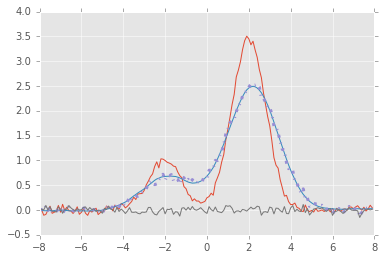

In [77]:
from numpy.polynomial.chebyshev import chebval

# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 2   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
spatialKernelOrder = 0 #2  # polynomial for modifying the shape of the kernel across the image
spatialBackgroundOrder = 0 #1  # polynomial for adding background gradient to fit
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebBasis(x, ord):
    coef = np.zeros(ord+1)
    coef[-1] = 1
    ch = chebval(x, coef)
    return ch, coef

def chebGauss(x, m=0., s=1., ord=0, beta=1.):
    ga = gaussian(x, m, s/beta)
    ch, coef = chebBasis(x, ord)
    print s, ord, coef
    return ga * ch

x = np.arange(-6, 6, 0.1)
basis = [chebGauss(x, m=0, s=sig, ord=deg, beta=betaGauss) \
         for i,sig in enumerate(sigGauss) for deg in range(degGauss[i])] #, kernelOrd=ko) for ko in range(spatialKernelOrder+1)]
basis = np.vstack(basis).T  # put the bases into columns

# Single call to do it with all bases
# First make the original (non spatially modified) basis
basis2 = [np.convolve(im1, b, mode='same') - im1 for b in basis.T]
basis2 = np.vstack(basis2).T

# Then make the spatially modified basis by simply multiplying the constant
#  basis (basis2 from above) by a polynomial along the image coordinate.
# Note that since we are *not* including i=0, this *does not include* basis2.
if spatialKernelOrder > 0:
    xx = xim/np.max(np.abs(xim))
    basis2m = [b * xx**i for i in range(1, spatialKernelOrder+1) for b in basis2.T]
    basis2m = np.vstack(basis2m).T
    basis2 = np.hstack([basis2, basis2m])

# Then make the spatial background part
if spatialBackgroundOrder >= 0:
    bgBasis = [chebBasis(xim, ord)[0] for ord in range(spatialBackgroundOrder+1)]
    bgBasis = np.vstack(bgBasis).T

pars, resid, _, _ = np.linalg.lstsq(basis2, im2)
print resid; print pars
fit = (pars * basis2).sum(1)
print basis2.shape, fit.shape, pars.shape
#plt.plot(x, im2 - fit)  # science - convolved template (red)
#plt.plot(x, im2 - im1)  # science - original template (blue)
plt.plot(xim, im1)  # original template (red)
plt.plot(xim, fit)  # convolved template (blue)  -- note looks purple because it's right on top of im2
plt.plot(xim, im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(xim, im2 - fit)  # diffim (grey)

print np.sum((im2-fit)**2), np.sum((im2-im1)**2)

1.02111375469


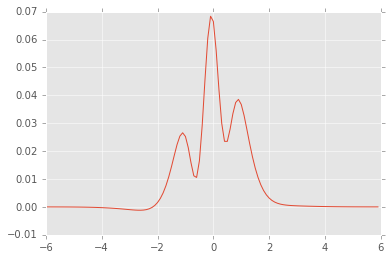

In [78]:
kfit = (pars * basis).sum(1)
print kfit.sum()
kfit /= kfit.sum()
plt.plot(x, kfit)  # this plots the matching kernel

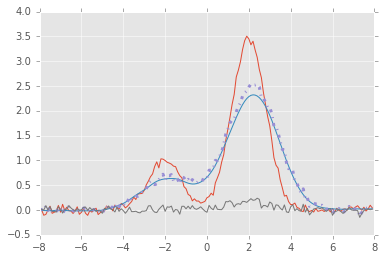

In [79]:
conv_im1 = np.convolve(im1, kfit, mode='same')
plt.plot(xim, im1)  # original template (red)
plt.plot(xim, conv_im1)  # convolved template (blue)
plt.plot(xim, im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(xim, im2 - conv_im1)  # diffim (grey)

In [80]:
## Compute the "L(ZOGY)" post-conv. kernel from kfit

-0.000237464513908
-0.000244546254651
1.40719508946


(-0.001, 0.001)

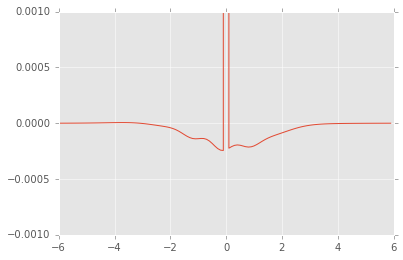

In [81]:
def kernel_ft(x, kernel):
    kp = kernel
    npts = len(x)
    FFT = fft(kp)
    FFT *= (x[1]-x[0])
    freqs = fftfreq(npts, x[1]-x[0])  # assumes uniformly sampled x!
    return FFT, freqs
def post_conv_kernel_ft(x, kernel, sig1=1., sig2=1.):
    kft, freqs = kernel_ft(x, kernel)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2)), freqs
def post_conv_kernel(x, kernel, sig1=1., sig2=1.):
    kft, freqs = post_conv_kernel_ft(x, kernel, sig1, sig2)
    out = ifft(kft)
    return out

pck = post_conv_kernel(x, kfit, sig1=sig1, sig2=sig2)
print pck.real.max() - np.sqrt(2.)
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(-0.001, 0.001) #; plt.xlim(-2, 2)

## Now convolve the image difference with the kernel.

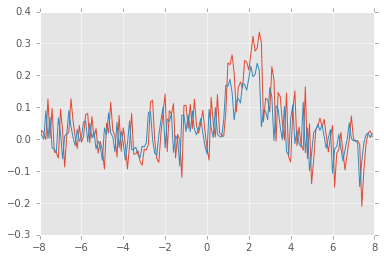

In [82]:
pck = np.fft.ifftshift(pck.real)
pci = np.convolve(im2-conv_im1, pck, mode='same')
plt.plot(xim, pci); plt.plot(xim, im2-conv_im1)